# Activity 6: Creating an active training environment
In this activity we learn to evaluate our LSTM model and to actively train it with new data.

## Load Data

In [1]:
%autosave 5

#  Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

from keras.models import load_model
from keras.callbacks import TensorBoard
from datetime import datetime, timedelta

from scripts.utilities_activity6 import *

np.random.seed(0)

Autosaving every 5 seconds


In [2]:
#  Load datasets
train = pd.read_csv('train_dataset.csv')
test = pd.read_csv('test_dataset.csv')

In [3]:
#  Group data into groups containing seven observations
train_data = create_groups(
    train['close_point_relative_normalization'][2:].values)

test_data = create_groups(
    test['close_point_relative_normalization'][:-3].values)

In [4]:
#  Reshape the data in the format expected by the LSTM layer
X_train, Y_train = split_lstm_input(train_data)

## Re-train Model with TensorBoard

In [5]:
def train_model(model, X, Y, epochs, version, run_number):
    """Training a model with TensorBoard callback.

    This function names each run of the model
    using the TensorBoard naming conventions.

    Parameters
    ----------
    model: Keras model instance
        Compiled Keras model.

    X, Y: np.array
        Series of observations to be used in
        the training process.

    epochs: int
        The number of epochs to train the
        model for.

    version: int
        Version of the model to run.

    run_number: int
        The number of the run. Used in case
        the same model version is run again.
    """
    model_name = f'bitcoin_lstm_v{version}_run_{run_number}'
    tensorboard = TensorBoard(log_dir=f'./logs/{model_name}')

    #  TASK:
    #  Modify the `fit` method to include a TensorBoard callback.
    #
    model_history = model.fit(
        x=X, y=Y,
        batch_size=1, epochs=epochs,
        callbacks = [tensorboard],
        shuffle=False)

    return model_history

In [6]:
#  Load previously trained network
model = load_model('bitcoin_lstm_v0.h5')

In [7]:
#  Retrain network
model_history = train_model(model=model,
                            X=X_train, Y=Y_train,
                            epochs=60,
                            version=0, run_number=4)

Epoch 1/60
1/1 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 2/60
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1/1 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 3/60
1/1 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 4/60
1/1 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 5/60
1/1 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 6/60
1/1 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 7/60
1/1 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 8/60
1/1 [==============================] - 0s 8ms/step - loss: 0.0012
Epoch 9/60
1/1 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 10/60
1/1 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 11/60
1/1 [==============================] - 0s 4ms/step - loss: 9.3836e-04
Epoch 12/60
1/1 [==============================] - 0s 3ms/step - loss: 8.55

## Evaluate LSTM Model

In [8]:
#  Combine training and testing datasets
combined_set = np.concatenate((train_data, test_data), axis=1)

In [9]:
#  Evaluate model at each week for the test set
evaluated_weeks = []
for i in range(0, test_data.shape[1]):
    input_series = combined_set[0:, i:i + 77]

    X_test = input_series[0:, :-1].reshape(1, input_series.shape[1] - 1, 7)
    Y_test = input_series[0:, -1:][0]

    result = model.evaluate(x=X_test, y=Y_test, verbose=0)
    evaluated_weeks.append(result)

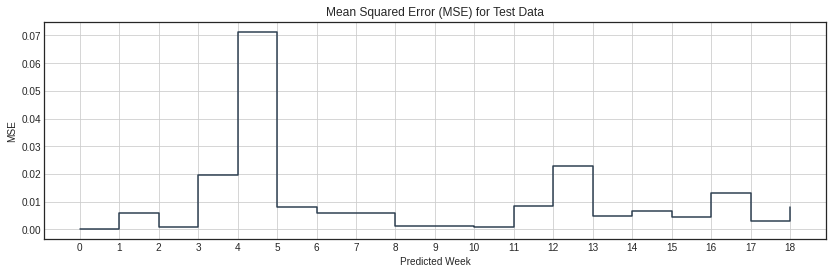

In [10]:
#  Plot MSE for all evaluated weeks
ax = pd.Series(evaluated_weeks).plot(drawstyle="steps-post",
                                     figsize=(14, 4),
                                     color='#2c3e50',
                                     grid=True,
                                     title='Mean Squared Error (MSE) for Test Data')

ax.set_xticks(range(0, len(evaluated_weeks)))
ax.set_xlabel("Predicted Week")
ax.set_ylabel("MSE")
plt.show()

## Interpreting Model Results

### Make Predictions

In [11]:
#  Make predictions for each of the 19 weeks
#  in the test set
predicted_weeks = []
for i in range(0, test_data.shape[1]):
    input_series = combined_set[0:, i:i + 76]
    predicted_weeks.append(model.predict(input_series))

In [12]:
#  Flatten `predicted_weeks` to get a list
#  of predictions for each day in the 19 weeks
predicted_days = []
for week in predicted_weeks:
    predicted_days += list(week[0])

In [13]:
#  Create list of dates associated with predictions
last_day = datetime.strptime(train['date'].max(), '%Y-%m-%d')
list_of_days = []
for days in range(1, len(predicted_days) + 1):
    D = (last_day + timedelta(days=days)).strftime('%Y-%m-%d')
    list_of_days.append(D)

In [14]:
#  Create dataframe with predicted values
predicted = pd.DataFrame({
    'date': list_of_days,
    'close_point_relative_normalization': predicted_days
})
predicted.head()

,date,close_point_relative_normalization
0,2017-06-25,0.001361
1,2017-06-26,0.013668
2,2017-06-27,0.066838
3,2017-06-28,0.057302
4,2017-06-29,0.057642


In [18]:
predicted['date'][0]

'2017-06-25'

In [20]:

#predicted['date'] = predicted['date'].apply(lambda x: datetime.strftime(x, "'%Y-%m-%d'"))
#test['date'] = test['date'].apply(lambda x: datetime.strftime(x, "'%Y-%m-%d'"))
#  Convert `date` variable to datetime
predicted['date'] = predicted['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

test['date'] = test['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [21]:
def plot_two_series(A, B, variable, title):
    """Plot two series using the same `date` index. 
    
    Parameters
    ----------
    A, B: pd.DataFrame
        Dataframe with a `date` key and a variable
        passed in the `variable` parameter. Parameter A
        represents the "Observed" series and B the "Predicted"
        series. These will be labelled respectively. 
    
    variable: str
        Variable to use in plot.
    
    title: str
        Plot title.
    """
    plt.figure(figsize=(14, 4))
    plt.xlabel('Observed and predicted')

    ax1 = A.set_index('date')[variable].plot(
        color='#d35400', grid=True, label='Observed', title=title)

    ax2 = B.set_index('date')[variable].plot(
        color='grey', grid=True, label='Predicted')
    
    ax1.set_xlabel("Predicted Week")
    ax1.set_ylabel("Predicted Values")

    plt.legend()
    plt.show()

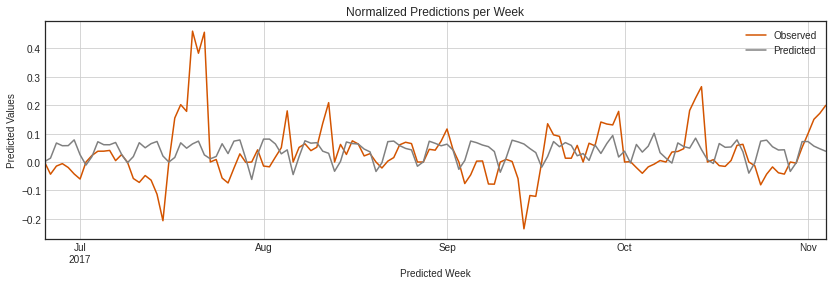

In [22]:
#  Plot predicted normalized prices
#  against actual normalized prices
plot_two_series(A=test[:-3],
                B=predicted,
                variable='close_point_relative_normalization',
                title='Normalized Predictions per Week')

### De-normalize Predictions

In [23]:
#  Add variable `iso_week` by stripping the Year and Week from `date`
predicted['iso_week'] = predicted['date'].apply(
    lambda x: x.strftime('%Y-%U'))

In [24]:
def denormalize(reference, series,
                normalized_variable='close_point_relative_normalization',
                denormalized_variable='close'):
    """Denormalize the values for a given series.

    Parameters
    ----------
    reference: pd.DataFrame
        DataFrame to use as reference. This dataframe
        contains both a week index and the USD price
        reference that we are interested on.

    series: pd.DataFrame
        DataFrame with the predicted series. The
        DataFrame must have the same columns as the
        `reference` dataset.

    normalized_variable: str, default 'close_point_relative_normalization'
        Variable to use in normalization.

    denormalized_variable: str, default `close`
        Variable to use in de-normalization.

    Returns
    -------
    A modified DataFrame with the new variable provided
    in `denormalized_variable` parameter.
    """
    week_values = reference[reference['iso_week'] == series['iso_week'].values[0]]
    last_value = week_values[denormalized_variable].values[0]
    series[denormalized_variable] = last_value * (series[normalized_variable] + 1)

    return series

In [25]:
#  Denormalize predictions
predicted_close = predicted.groupby('iso_week').apply(
    lambda x: denormalize(test[:-3], x))

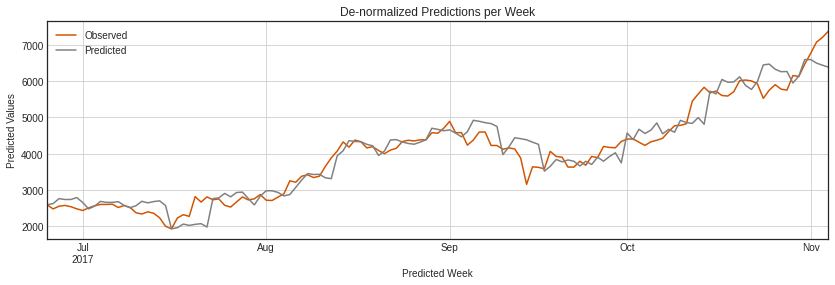

In [26]:
#  Plot denormalized predictions and observed closing prices in test set
plot_two_series(A=test[:-3],
                B=predicted_close,
                variable='close',
                title='De-normalized Predictions per Week')

### Calculate RMSE and MAPE

In [27]:
A = test[:-3]['close_point_relative_normalization']
B = predicted_close['close_point_relative_normalization']

print(f'Normalized RMSE: {rmse(A, B):.2f}')

Normalized RMSE: 0.10


In [28]:
A = test[:-3]['close']
B = predicted_close['close']

print(f'De-normalized RMSE: {rmse(A, B):.2f}')
print(f'De-normalized MAPE: {mape(A, B):.2f}')

De-normalized RMSE: 352.27
De-normalized MAPE: 6.78
